<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/NEW_RF(GFI)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic RF

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()


/tmp/ipython-input-670492372.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [4]:
# Train = 2014-01-01 to 2023-12-31
train = df.loc["2014-01-01":"2023-12-31"]
test = df.loc["2024-01-01":"2024-12-31"]

X_train = train.drop("Target", axis=1)
y_train = train["Target"]

X_test = test.drop("Target", axis=1)
y_test = test["Target"]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2538, 5) Test size: (249, 5)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
# Initialise and fit model
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)


Accuracy: 0.5060240963855421

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.73      0.58       115
           1       0.58      0.31      0.41       134

    accuracy                           0.51       249
   macro avg       0.53      0.52      0.49       249
weighted avg       0.53      0.51      0.49       249



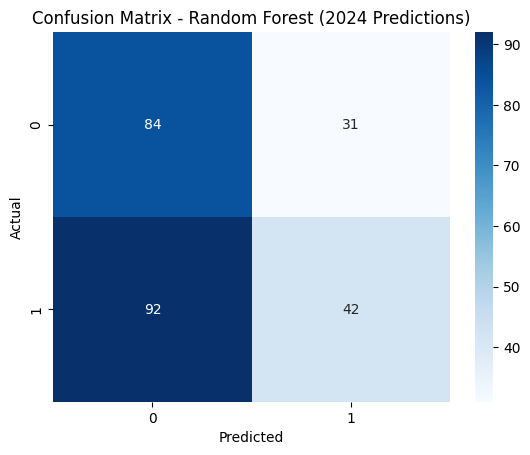

In [7]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest (2024 Predictions)")
plt.show()


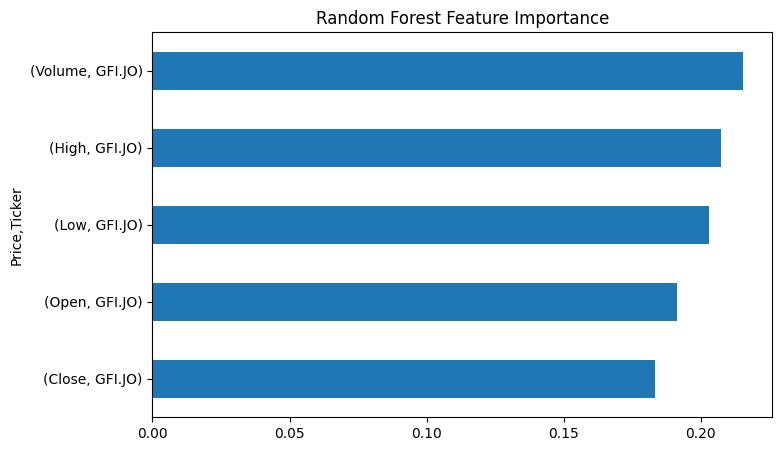

In [8]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Random Forest Feature Importance")
plt.show()


# Added features

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()


/tmp/ipython-input-670492372.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [3]:
# -------------------------------
# Feature Engineering
# -------------------------------
df = df.copy()

# 1. Lagged Returns (1–5 days)
df['Return'] = df['Close'].pct_change()
for lag in range(1, 6):
    df[f'Return_t-{lag}'] = df['Return'].shift(lag)

# 2. Lagged Volume (1–5 days)
for lag in range(1, 6):
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)

# 3. Ratios & Normalisations
df['Close_SMA20'] = df['Close'] / df['Close'].rolling(20).mean()  # only keep ratio
df['High_Low'] = df['High'] / df['Low']
df['Close_Open'] = df['Close'] / df['Open']


# 4. Volatility & Risk
df['RollingStd_20'] = df['Close'].rolling(20).std()
df['ATR_14'] = (df['High'] - df['Low']).rolling(14).mean()
df['SquaredReturn'] = df['Return']**2

# 5. Momentum & ROC
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
df['ROC_5'] = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)


# RSI (14)
delta = df['Close'].diff()

gain = delta.where(delta > 0, 0)   # keep positive diffs
loss = -delta.where(delta < 0, 0)  # keep negative diffs

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))



# MACD (12,26) and Signal (9)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger %B (20, 2 std)
sma20 = df['Close'].rolling(20).mean()
std20 = df['Close'].rolling(20).std()
upper = sma20 + 2 * std20
lower = sma20 - 2 * std20
df['Bollinger_%B'] = (df['Close'] - lower) / (upper - lower)

# 7. Volume Indicators
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df['MFI'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['VPT'] = (df['Volume'] * (df['Close'].pct_change())).cumsum()

# 8. Z-Scores
for win in [5, 10, 20]:
    rolling_mean = df['Close'].rolling(win).mean()
    rolling_std = df['Close'].rolling(win).std()
    df[f'ZScore_{win}'] = (df['Close'] - rolling_mean) / rolling_std

# 9. Sharpe-like ratio
df['SharpeLike_20'] = df['Return'].rolling(20).mean() / df['Return'].rolling(20).std()

# -------------------------------
# Finalise Dataset
# -------------------------------
df.dropna(inplace=True)

# Define Features (same for KNN, SVM, RF, XGBoost)
features = [
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Close_SMA20','High_Low','Close_Open',
    'RollingStd_20','ATR_14','SquaredReturn',
    'Momentum_5','Momentum_10','ROC_5','ROC_10',
    'RSI_14','MACD','MACD_Signal','Bollinger_%B',
    'OBV','MFI','VPT',
    'ZScore_5','ZScore_10','ZScore_20',
    'SharpeLike_20'
]

X = df[features]
y = df['Target']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Feature matrix shape: (2977, 31)
Target distribution:
 Target
0    1525
1    1452
Name: count, dtype: int64


In [4]:
# Split dataset into train (2014–2023) and test (2024)
train = df.loc["2014-01-01":"2023-12-31"]
test = df.loc["2024-01-01":"2024-12-31"]

X_train = train[features]
y_train = train["Target"]

X_test = test[features]
y_test = test["Target"]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (2497, 31) Test size: (249, 31)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialise RF model
rf = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=12,           # max depth per tree
    random_state=42,
    class_weight="balanced_subsample"  # balances class imbalance
)

# Fit on training data
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       n_estimators=300, random_state=42)

Random Forest Accuracy (2024): 0.4779116465863454

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.83      0.60       115
           1       0.55      0.17      0.26       134

    accuracy                           0.48       249
   macro avg       0.51      0.50      0.43       249
weighted avg       0.51      0.48      0.42       249



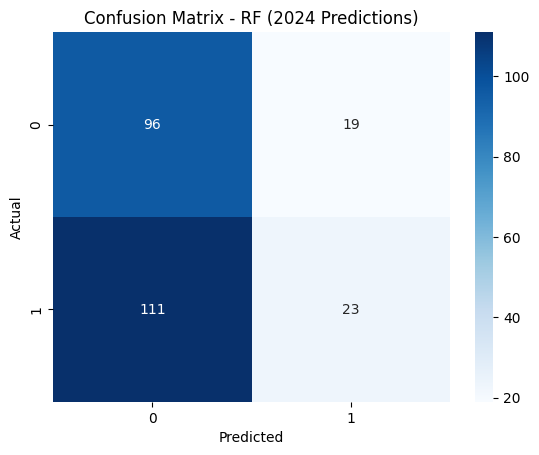

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = rf.predict(X_test_scaled)

# Accuracy & report
print("Random Forest Accuracy (2024):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - RF (2024 Predictions)")
plt.show()


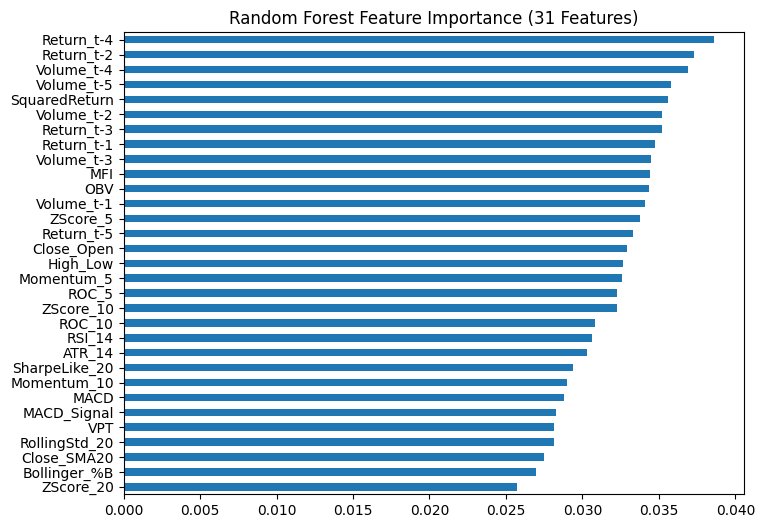

In [8]:
import pandas as pd

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features)

# Plot
importances.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Random Forest Feature Importance (31 Features)")
plt.show()


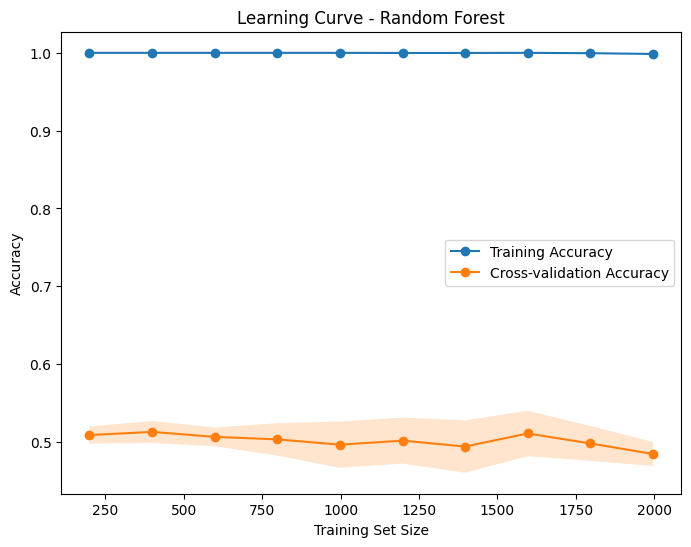

In [9]:
from sklearn.model_selection import learning_curve
import numpy as np

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train_scaled, y_train, cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42,
    n_jobs=-1
)

# Mean and std of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation Accuracy")

# Shaded std regions
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend(loc="best")
plt.show()
